<a href="https://colab.research.google.com/github/EktaSingh1612/LGMVIP/blob/main/stock_market_prediction_and_forecasting_using_stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGMVIP Data Science Internship

## Author : EKTA SINGH

## Beginner Level Task 2 - Stock Market Prediction And Forecasting Using Stacked LSTM

### Technique used: Deep Learning: Stacked Long Short Term Memory (LSTM)



# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Importing datasets

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df.head(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


# Investigating the dataset

In [5]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [6]:
df.shape

(2035, 8)

In [8]:
df.tail(5)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


Hence, here total of 2035 days of data is there from 28/09/2018 to 21/07/2010.

So let's analyse with closing stock price (we can do it with any other too) throughout & how it performed for each day by ploting graph.

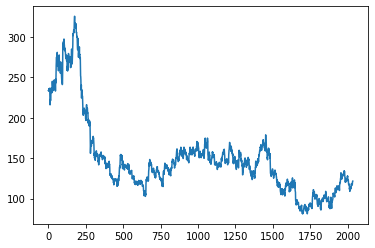

In [12]:
plt.plot(df['Close'])

Lets make a new variable for just closing stock price so as to train the model.

In [13]:
df_close = df.reset_index()['Close']
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [14]:
# LSTM are sensitive to the scale of the data, so we apply MinMax scaler where we tranfer the values between 0 to 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)) #defining the range
df_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
print(df_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


In [15]:
# In time series case the data is always depend on the preivious dates of the data
# split dataset into train and test split

training_size = int(len(df_close)*0.70) #define the size of the training data (65%)
test_size = len(df_close) - training_size
train_data,test_data = df_close[0:training_size,:],df_close[training_size:len(df_close),:1]
print(training_size,test_size)

1424 611


here since the data is dependent on the previous data so here we consider timesteps to identify the x_train data and y_train data. let's suppose we consider timesteps=3 then our x_train data contain first 3 values and y_train data contains the 4th values similarly we do this for 5th value=2nd+3rd+4th value in our feature model.

For Example consider:

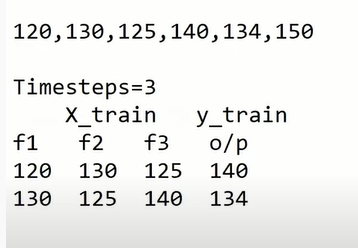

Now consider this data to train our LSTM model We will do this for our test data also.

In [16]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 means at i =0 the 0,1,2,3 elements will be going in a and in x_train the dirst 3 elemets will come and in y train the 4th element will.
    #note: this happens only when the timestep =3, the data will change depend on your timestep
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [17]:
# more the number of timestep more accurately the result will come
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100 # here the number of timestep we consider is 100 for better prediction
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step) # call the method create_dataset()

In [18]:
print(X_train)

[[0.62418301 0.62214052 0.62622549 ... 0.83455882 0.86213235 0.85273693]
 [0.62214052 0.62622549 0.63378268 ... 0.86213235 0.85273693 0.87111928]
 [0.62622549 0.63378268 0.62234477 ... 0.85273693 0.87111928 0.84497549]
 ...
 [0.26041667 0.2563317  0.24652778 ... 0.33415033 0.33986928 0.34681373]
 [0.2563317  0.24652778 0.23611111 ... 0.33986928 0.34681373 0.3500817 ]
 [0.24652778 0.23611111 0.25204248 ... 0.34681373 0.3500817  0.32618464]]


In [19]:
print(X_train.shape), print(y_train.shape)

(1323, 100)
(1323,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)
# 100 is showing the number of timesteps of 510 records in x_test

(510, 100)
(510,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
#here we convert these array into 3d array because we need only the timestep and the nummber of feature in the training data and 1 is represnting the z -axis of 3d array.


# Train the model

In [22]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
#adding layers in LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

## What Is an Epoch?

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm.

## verbose

By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

verbose=0 will show you nothing (silent)

verbose=1 will show you an animated progress bar like this:

progres_bar

verbose=2 will just mention the number of epoch like this:

enter image description here

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 19s 263ms/step - loss: 0.0170 - val_loss: 0.0064
Epoch 2/100
21/21 [==============================] - 4s 208ms/step - loss: 0.0021 - val_loss: 9.4925e-04
Epoch 3/100
21/21 [==============================] - 4s 206ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
21/21 [==============================] - 4s 206ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
21/21 [==============================] - 4s 201ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/100
21/21 [==============================] - 4s 205ms/step - loss: 0.0013 - val_loss: 8.9787e-04
Epoch 7/100
21/21 [==============================] - 4s 206ms/step - loss: 0.0013 - val_loss: 9.7416e-04
Epoch 8/100
21/21 [==============================] - 4s 202ms/step - loss: 0.0011 - val_loss: 9.7285e-04
Epoch 9/100
21/21 [==============================] - 6s 267ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/100
21/21 [==============================] - 4s 202ms/step - loss

In [24]:
import tensorflow as tf
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [25]:
### Calculate RMSE performance metrics for our training data
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

165.92204408598118

In [26]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

108.96793056942464

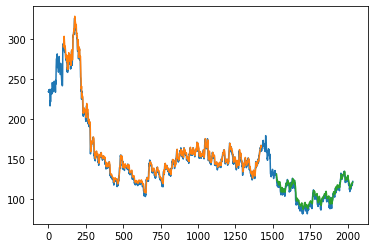

In [28]:
#Predict the test data and plot the output
# shift train predictions for plotting
look_back=100 #size of timesteps
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

here orange color define the traing data and green color define the output data or prediction data from test data

Now lets predict the output for next 30 days.For this first calculate the length of the test data. for example suppose the last date of the test data is 22May and now I want to predict for 23 May so we want last 100 data (for timesteps) for our new prediction.

In [29]:
len(test_data)

611

here the length is 611 so we will take data from 511

In [30]:
x_input=test_data[511:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input) # convert all the input of x_input into a lists and extract previous 100 data from test_data
temp_input=temp_input[0].tolist()
temp_input

[0.12479575163398693,
 0.1384803921568627,
 0.14011437908496732,
 0.1388888888888889,
 0.13541666666666663,
 0.14011437908496732,
 0.13807189542483655,
 0.130718954248366,
 0.130718954248366,
 0.12867647058823528,
 0.11846405228758167,
 0.14644607843137253,
 0.1480800653594771,
 0.159109477124183,
 0.15992647058823523,
 0.1578839869281045,
 0.16441993464052285,
 0.178921568627451,
 0.17933006535947704,
 0.19260620915032678,
 0.2081290849673203,
 0.18974673202614378,
 0.18055555555555558,
 0.1823937908496731,
 0.17708333333333326,
 0.17810457516339862,
 0.18055555555555558,
 0.17810457516339862,
 0.17851307189542487,
 0.196078431372549,
 0.18913398692810457,
 0.1895424836601307,
 0.19403594771241828,
 0.19444444444444442,
 0.20200163398692816,
 0.19771241830065356,
 0.19934640522875813,
 0.19873366013071891,
 0.19975490196078427,
 0.21282679738562094,
 0.21568627450980393,
 0.2044526143790849,
 0.21772875816993464,
 0.21098856209150318,
 0.21425653594771243,
 0.1975081699346406,
 0.1881

In [32]:
# demonstrate prediction for next 30 days
'''In this what we are doing is that we predict the values for 30 days with the help of while loop and first of all it will go to the else condition because initially
we have 100 data values and in else part we give new data to our trained model and then add predicted value in our test_input list and then it will go in if condition 
because now the values will 101 and then again it will give the values to model and predict new value and do this for 30 times.'''
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16913886]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [33]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)
len(df_close)

2035

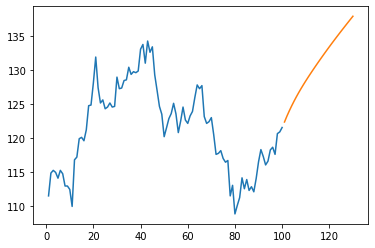

In [36]:
plt.plot(day_new,scaler.inverse_transform(df_close[1935:])) #displays as real data here 1935 is taken because we want last 100 data for our predicted data from df1
plt.plot(day_pred,scaler.inverse_transform(lst_output)) #displays the predicted data

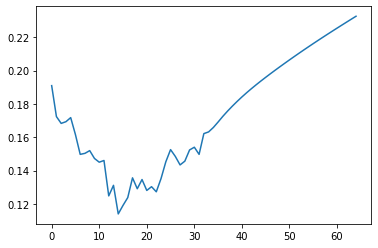

In [37]:
# to display the graph more largerly
df3 = df_close.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

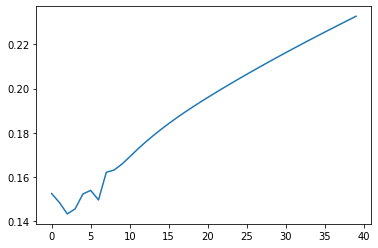

In [39]:
# to display the graph more largerly
df3=df_close.tolist()
df3.extend(lst_output)
plt.plot(df3[2025:])